In [1]:
import scipy.optimize

import Modules.SQcircuit_extensions as sq_ext
import Modules.perturbation_theory as pt
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 
import scipy as sp
from scipy.optimize import curve_fit, minimize

# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
reload(sq_ext)
reload(sq)
reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

<Figure size 640x480 with 0 Axes>

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Qubit - Cavity 2xN effective Hamiltonian - vs $\varphi_{ext}$

In [3]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# L_C_eff = 1e100 

In [4]:
n_eig  = 8

nmax_f=15
nmax_r=10

# basis_states = []
# N = 2
# for i in range(N):
#     basis_states.append((0,i))
#     basis_states.append((1,i))

basis_states = []
N = 2
for q in [0,1,2]:
    for n in range(N):
        basis_states.append((q, n))

# basis_states = []
# N = 2
# for n in range(N):
#     for q in [0,1,2]:
#         basis_states.append((q, n))

N_elements = 2
max_excitations_mediating_states = 2
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i},{j})' for i, j in basis_states]
labels_low
# labels_high = [f'({i},{j})' for i, j in mediating_states]

['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(2,0)', '(2,1)']

In [5]:
reload(sq_ext)

n_plot = 200
φ_ext_values = np.linspace(0.5, 0.65, n_plot)

fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5,nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ,nmax_r=nmax_r)
Hf = fluxonium_0.hamiltonian()
Hr = resonator.hamiltonian()
H_0_list =[Hf,Hr]

H_0, E_0, ψ_0_basis, ψ_0_mediating = sq_ext.ψ_0_from_H_0(H_0_list, basis_states, mediating_states, n_eig)
E_0_ψ_0_basis = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_basis]
subspace_indices = sq_ext.find_close_indices_unique(E_0_ψ_0_basis, E_0)

print(subspace_indices)

[0, 2, 1, 4, 3, 7]


C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:2210: RuntimeWarning: invalid value encountered in divide
  avgz = avgz / np.abs(avgz)


In [6]:
E_vs_φ_ext = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_full_vs_φ_ext = np.zeros([len(φ_ext_values), n_eig]) 
H_eff_SWT_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')
H_eff_p1_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')
H_eff_SWT_decomp_vs_φ_ext = np.zeros([len(φ_ext_values),9, 4], dtype='complex')
for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff )
    
    E, ψ = sq_ext.diag(H, n_eig, out='GHz', solver='Qutip', qObj=True, remove_ground=True)
    E_basis = E[subspace_indices]
    ψ_basis = ψ[subspace_indices]
    
    E_full_vs_φ_ext[i] = E
    E_vs_φ_ext[i] = np.sort(E_basis)
    
    H_eff_SWT_vs_φ_ext[i] = sq_ext.H_eff_SWT_large(ψ_0_basis, ψ_basis, E_basis )
    H_eff_p1_vs_φ_ext[i] = sq_ext.H_eff_p1_large(ψ_0_basis, H, out='GHz', real=True, remove_ground=False)
    
    # H_eff_SWT_decomp_vs_φ_ext[i] = sq_ext.decomposition_in_pauli_3xN_qutrit_resonator(H_eff_SWT_vs_φ_ext[i], print_pretty=False)

In [7]:
reload(sq_ext)

H0_f  = fluxonium_0.hamiltonian()
E0_f, ψ0_f = sq_ext.diag(H0_f, 3, solver='numpy', qObj=True, remove_ground=True)

ωq_01 = E0_f[1]
ωq_02 = E0_f[2]

ω_r = sq_ext.diag(Hr,2, remove_ground=True)[0][1]
gΦ_λ1, gΦ_λ6 = sq_ext.get_parameters_qutrit_cavity(fluxonium, resonator, L_C_eff)

E_uc_qutrit_cavity_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states)])

for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H = fluxonium.hamiltonian()
    E_f_vs_φ_ext, ψ_f = sq_ext.diag(H, 3, solver='numpy', qObj=True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ0_f, ψ_f, E_f_vs_φ_ext, remove_I=True)
    H_eff_SWT_decomp_f = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False)
    
    g_λ = H_eff_SWT_decomp_f
    g_λ1, g_λ3, g_λ4, g_λ6, g_λ8 =[g_λ[1], g_λ[3]+ωq_01/2, g_λ[4], g_λ[6], g_λ[8]-(ωq_01 - 2 * ωq_02) / 2 / np.sqrt(3) ]
    
    H_uc_qutrit_cavity = sq_ext.hamiltonian_uc_qutrit_cavity(ωq_01, ωq_02, g_λ1, g_λ3, g_λ4, g_λ6, g_λ8, ω_r, gΦ_λ1, gΦ_λ6, N = 2)
    E_uc_qutrit_cavity_vs_φ_ext[i] = sq_ext.diag(H_uc_qutrit_cavity,n_eig=len(basis_states), out=None, solver='numpy', remove_ground=True)[0]

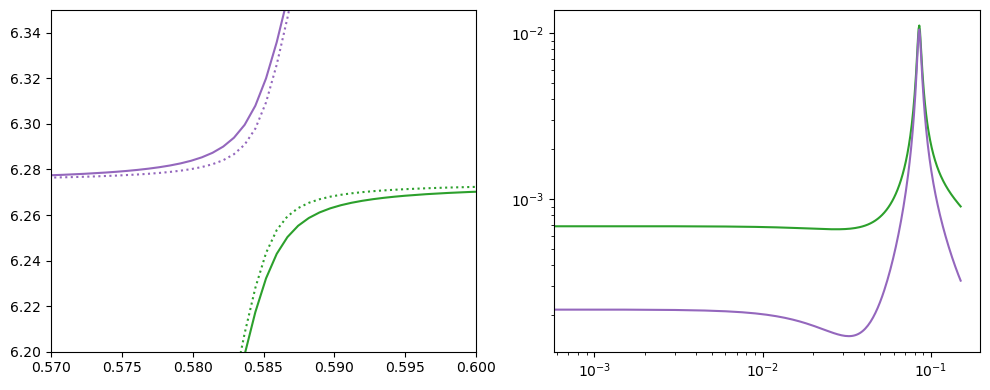

In [9]:
colors = figs.generate_colors_from_colormap(len(basis_states),'tab10')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4])

for i in range(1, len(basis_states)):
    ax1.plot(φ_ext_values, E_vs_φ_ext[:,i], color= colors[i])
    ax1.plot(φ_ext_values, E_uc_qutrit_cavity_vs_φ_ext[:,i], ':', color= colors[i])

for i in range(1, 3):    
    ax2.plot(φ_ext_values-0.5, np.abs(E_vs_φ_ext[:,i]-E_uc_qutrit_cavity_vs_φ_ext[:,i]), color= colors[i])

ax1.set_ylim([6.2, 6.35])
ax1.set_xlim([0.57,0.6])
    
ax2.set_yscale('log')
ax2.set_xscale('log')
fig.tight_layout()

In [42]:
sq_ext.decomposition_in_pauli_3xN_qutrit_resonator(H_eff_SWT_vs_φ_ext[0], test_decomposition=True);

10.9191+0.0000j	*	λ_0 ⊗ I
6.2738+0.0000j	*	λ_0 ⊗ n
0.0617+0.0000j	*	λ_1 ⊗ a†+a
-1.7117-0.0000j	*	λ_3 ⊗ I
0.0014+0.0000j	*	λ_3 ⊗ n
-0.0039-0.0000j	*	λ_4 ⊗ n
0.0715-0.0000j	*	λ_6 ⊗ a†+a
-3.9301+0.0000j	*	λ_8 ⊗ I
-0.0035+0.0000j	*	λ_8 ⊗ n

Original eigenvalues:
[0.000000000000 3.421970000000 6.274940000000 8.514880000000 9.698900000000 14.797510000000]
Reconstructed eigenvalues:
[0.000000000000 3.421970000000 6.274940000000 8.514880000000 9.698900000000 14.797510000000]
Spectra match (within tolerance).


In [43]:
sq_ext.decomposition_in_pauli_3xN_qutrit_resonator(H_eff_p1_vs_φ_ext[0], test_decomposition=True);

10.9193+0.0000j	*	λ_0 ⊗ I
6.2740+0.0000j	*	λ_0 ⊗ n
0.0617+0.0000j	*	λ_1 ⊗ a†+a
-1.7117+0.0000j	*	λ_3 ⊗ I
0.0715+0.0000j	*	λ_6 ⊗ a†+a
-3.9304+0.0000j	*	λ_8 ⊗ I

Original eigenvalues:
[0.000000000000 3.421970000000 6.275730000000 8.515450000000 9.702460000000 14.794230000000]
Reconstructed eigenvalues:
[0.000000000000 3.421970000000 6.275730000000 8.515450000000 9.702460000000 14.794230000000]
Spectra match (within tolerance).


In [49]:
fluxonium_0.diag(3);
resonator.diag(3);

In [54]:
Φf = fluxonium_0.flux_op(0,'eig')
Φf

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 5.74457128e-14+1.76309257e-29j  3.16564145e+01+2.31458961e-14j  1.67934174e-13+2.17992928e-14j]
 [ 3.16564145e+01-2.31458961e-14j -3.03154215e-13-2.58567891e-29j  3.66887856e+01-1.42335482e-14j]
 [ 1.67934174e-13-2.17992928e-14j  3.66887856e+01+1.42335482e-14j  2.77827506e-13-6.03971631e-31j]]

In [55]:
Φr = resonator.flux_op(0,'eig')
Φr

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[-1.07668768e-14+1.74128728e-30j  4.46266064e+01-3.13077834e-14j -2.88328904e-14+1.81922644e-14j]
 [ 4.46266064e+01+3.13077834e-14j  4.68715905e-14-5.56615588e-32j  6.31115520e+01+1.81553314e-14j]
 [-2.88328904e-14-1.81922644e-14j  6.31115520e+01-1.81553314e-14j  1.70643772e-13-2.20997806e-30j]]

In [62]:
Φf[0,1] * Φr[0,1] / (L_C_eff * nH) / 2 / np.pi / GHz

(0.06168113036063489+1.8263799265444887e-18j)

In [74]:
Φf[1,2] * Φr[0,1] / (L_C_eff * nH) / 2 / np.pi / GHz

(0.07148648387376458-7.788476524912485e-17j)

In [ ]:
def 